In [ ]:
# Klasterizuojami ML anotuoti pūpsniai atskirai kiekvienoje iš grupių
# su ML anotacijomis N, S, V.  
# 
# Klasterizacija atliekama esant pakankamam N, S ar V grupės dydžiui. U grupė neklasterizuojama.
#  
# Skriptas EKG įrašo pūpsnių klasterizacijai panaudojant VU FDA požymius
# Šis variantas pritaikytas įrašams, kuriems rpeaks surandami su Neurokitu,
# o anotacijos yra gautos su ML.anotuotams įrašams. Yra ir kitas variantas
# (zive_clustering_of_annotated_records.ipynb), pritaikytas darbui su rpeaks
# ir anotacijomis, atsisiųtomis iš duomneų bazės.   

# Planas:
# Nuskaitome EKG įrašą
# Surandame su Neurokit2 R pikus
# Apskaičiuojame visiems pūpsniams požymius ir suformuojame požymių masyvą
# Surandame visiems R pikams ML anotacijas
# Atliekame klasterizaciją
# Atvaizduojame klasterius grafiškai

import tensorflow as tf
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import time
import sys, os, json
from pathlib import Path
import pickle
import sklearn
import neurokit2 as nk
from zive_clustering import get_sequences_min_max, show_beats, show_beats_in_same_plot


my_os=sys.platform
print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Į sys.path įtraukiamas aukščiau esantis aplankas, reikalingas modulių importavimui
# https://www.geeksforgeeks.org/get-parent-of-current-directory-using-python/ panaudojau šitą
path = os.getcwd() # Current Directory
parent = os.path.dirname(path) # parent directory
sys.path.insert(1, parent)

from zive_util_vu import runtime
from zive_cnn_fda_vu_v3_micro import get_beat_features_set_fda_vu_v1_micro
from zive_util_vu import create_dir, get_rec_file_name, get_recId
from zive_util_vu import get_seq_start_end, read_rec, read_rec_attrib, split_SubjCode
from zive_cnn_fda_vu_v3_micro import read_RR_arr_from_signal, read_seq_from_signal

np.set_printoptions(threshold=sys.maxsize)
print('tf version:', tf.__version__)
print('sklearn version:', sklearn.__version__)


In [ ]:
# Pagrindinis skriptas

print("Skriptas bandymams klasterizuoti EKG įrašo pūpsnius su ML anotacijomis kiekvienai anotacijai atskirai")
print('Naudojami VU FDA požymiai, scaler ir modelio parametrai nuskaitomi iš modelio CNN VU aplanko')


# //////////////// NURODOMI DUOMENŲ PARAMETRAI /////////////////////////////////////////////////////

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'D:\\DI'   # variantas: Windows
    # Duomenu_aplankas = 'F:\DI\Data\MIT&ZIVE\VU'   # variantas: Herkulis
else:
    Duomenu_aplankas = '/home/kesju/DI'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

# Vietinės talpyklos aplankas ir pūpsnių atributų failas
db_folder = 'DUOM_2022_RUDUO_2'

# Failai pūpsnių klasių formavimui
selected_beats = {'N':0, 'S':1, 'V':2}
all_beats =  {'N':0, 'S':1, 'V':2, 'U':3}  

# Diskretizavimo dažnis:
fs = 200

#  Nuoroda į aplanką su duomenų rinkiniu
db_path = Path(Duomenu_aplankas, db_folder)

# Nuoroda į aplanką su EKG įrašais (.npy) ir anotacijomis (.json)
rec_dir = Path(db_path, 'records_npy')

# Nuoroda į modelio aplanką
# model_dir = Path(Duomenu_aplankas, 'DNN', 'best_models', 'all_ft')
model_dir = 'model_cnn_fda_vu_v1'

# Išvedame parametrus
print("\nBendras duomenų aplankas: ", Duomenu_aplankas)
print("Zive duomenų aplankas: ", db_folder)
print("Aplankas su originaliais EKG įrašais ir anotacijomis (.json) ", rec_dir)
print("Diskretizavimo dažnis: ", fs)
print('Klasifikavimo schema:', selected_beats)
print('Klasių skaičius:', len(selected_beats))
print('Visos galimos anotacijos:', list(all_beats.keys()))
print("Scaler ir modelio parametrai nuskaitomi iš aplanko: ", model_dir)
# print("\n")


# mark1

# NURODOME PACIENTŲ SĄRAŠĄ. GALIMI ĮVAIRŪS VARIANTAI
# SubjCode = 105411   #Testavimui
# SubjCode = 101322   #Testavimui
# 22    1013   22	6144cd8bbd0cc52ca32753a4	1631032.393	862	0	49	0	849	6	39	17	2,90 - daug ML U
# SubjCode = 100817
# 62	1008	17	613f58593d08d461accdcd3f	1630810.723	665	0	7	3	662	0	3	10	0,30 - yra 3 rankinės U
# SubjCode = 106719
# 1067	19	61b32738cf0f345ce2cb1ce8	1638193.61	734	2	16	0	742	1	7	2
# SubjCode = 10703
# 1070	3	61b32860cf0f34eee2cb207e	1638807.647	543	0	4	0	541	0	1	5
SubjCode = 101322   #Testavimui
# 22    1013   22	6144cd8bbd0cc52ca32753a4	1631032.393	862	0	49	0	849	6	39	17	2,90 - daug ML U


# Užduodame klasterių skaičių
uzd_clusters=20

# //////////////// PASIRUOŠIMAS ////////////////////////////////////////////////////////////////////

pd.set_option("display.max_rows", 6000)
pd.set_option("display.max_columns",200)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

# Klasių simbolinių vardų sąrašas ir klasių skaičius
class_names = list(selected_beats.keys()) 
n_classes = len(selected_beats)
# print(class_names)

# Naudojamų požymių sąrašas 
all_features = ['seq_size','RR_l_0', 'RR_r_0', 'RR_r/RR_l','wl_side','wr_side',
                'signal_mean', 'signal_std', 'P_val', 'Q_val', 'R_val', 'S_val', 'T_val',
                'P_pos', 'Q_pos', 'R_pos', 'S_pos', 'T_pos', 'QRS', 'PR', 'ST', 'QT', '0', '1', '2',
                '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
                '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
                '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
                '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
                '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
                '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
                '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114',
                '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
                '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138',
                '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150',
                '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162',
                '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174',
                '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186',
                '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198',
                '199']

# nuskaitome modelio parametrus
model_path = Path(parent, model_dir, 'best_model_final_2.h5')
model = tf.keras.models.load_model(model_path)

 # Nuskaitome scaler objectą
path_scaler = Path(parent, model_dir, 'scaler.pkl')  
scaler = pickle.load(open(path_scaler,'rb'))


# //////////////// NUSKAITOMAS ĮRAŠAS /////////////////////////////////////////////////////

print("Klasterizuojamas įrašas:", SubjCode)
print("Užduota klasterių:", uzd_clusters)

start_time = time.time()

# Nuskaitome EKG įrašą (npy formatu)
file_path = Path(rec_dir, str(SubjCode) + '.npy')
sign_raw = np.load(file_path)
# sign_raw = read_rec(rec_dir, SubjCode)
signal_length = sign_raw.shape[0]
signal = sign_raw

# Surandame ir išvedame įrašo atributus
userNr, recNr = split_SubjCode(SubjCode)
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2} file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")


# //////// NUSTATOME rpeaak VIETAS, APSKAIČIUOJAME PŪPSNIŲ POŽYMIUS IR SURANDAME ML ANOTACIJAS //////////

# Nustatome R pikų vietas
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=200, correct_artifacts=False)
atr_sample = rpeaks['ECG_R_Peaks']
# print(type(atr_sample))
# print("Neurokit:",atr_sample[:50])


idx_lst = list(range(1, len(atr_sample)-1))  # pastaba: idx_lst sąrašas nuo 1 iki atr_sample-2

# Formuojame iš pūpsnių požymių masyvą: data_frame yra tik tos eilutės,
# kurių indeksai nepapuolė į omitted (atitinka automatines anotacijas 'U')
df_attr_features_be_U, omitted = get_beat_features_set_fda_vu_v1_micro(signal, atr_sample, idx_lst)

data_frame = df_attr_features_be_U.set_index('idx')
df_attr_features_be_U.columns = df_attr_features_be_U.columns.astype(str)

# paruošiame požymių masyvą klasifikatoriui
test_x = df_attr_features_be_U[all_features]
x_test = scaler.transform(test_x)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
# print("len(test_x):", len(test_x))

# Pūpsnių klasių atpažinimas (ML anotacijos)
predictions = model.predict(x_test)
atr_labels_be_U = np.argmax(predictions, axis=1)


# //////////////// PARUOŠIAME DUOMENŲ MASYVUS KLASTERIZACIJAI  //////////////////////////////////

# Parengiame R pikų ir ML anotacijų masyvus taip, kad juose nebūtų elementų iš omitted,
# taip pat atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)

# Atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)
atr_sample = atr_sample[idx_lst]
print("atmetus 1 ir paskutini:",len(atr_sample))
# print("atmetus 1 ir paskutini:", atr_sample[:50])

# Suformuojame atr_sample_be_U
atr_sample_be_U = atr_sample
idxs_su_U = []
if (not omitted.empty):
    idxs_su_U = list(omitted['idx'])
    print("idxs_su_U:",idxs_su_U)
    atr_sample_be_U = np.asarray([atr_sample[item] for item in range(len(atr_sample)) if (item not in idxs_su_U)])
print("atmetus su 'U':",len(atr_sample_be_U))
# print("atr_sample_be_U:", atr_sample_be_U[:50])

# Suformuojame atr_symbol_be_U panaudodami atpažintus atr_labels_be_U
invers_all_beats = {v: k for k, v in all_beats.items()}
atr_symbol_be_U = np.array([invers_all_beats[sample] for sample in atr_labels_be_U])
# print("atr_symbol_be_U:",atr_symbol_be_U[:50])

# Pūpsnių statistika
(unique, counts) = np.unique(atr_symbol_be_U, return_counts=True)
total = counts.sum()
print("class labels: ", unique, counts, total)

# Pridedame atributus atr_sample_be_U, atr_symbol_be_U prie požymių datafreimo,
# skirto klasterizacijai
df_attr_features_be_U['atr_sample'] = atr_sample_be_U
df_attr_features_be_U['atr_symbol'] = atr_symbol_be_U
print("\nMasyvas be U: df_attr_features_be_U len:", len(df_attr_features_be_U) )
# print(df_attr_features_be_U.columns)

# # Suformuojame masyvą su `U` df_attr_su_U, kuris bus naudojamas kaip atskiras klasteris
# # df_attr_su_U = pd.DataFrame(columns=['atr_sample', 'atr_symbol',  'cluster'])
df_attr_su_U = pd.DataFrame()
if (idxs_su_U):
    attr_su_U = []
    for item in idxs_su_U:
        dict_tmp = {
            'idx': item,
            'atr_sample': atr_sample[item],
            'atr_symbol': 'U',
            'cluster': 99
        }
        attr_su_U.append(dict_tmp)
    df_attr_su_U = pd.DataFrame(attr_su_U)
print("\nKlasteris su U: df_attr_su_U len:", len(df_attr_su_U) )
print(df_attr_su_U.head())

end_time = time.time()
print('\npožymiai:')
runtime(end_time-start_time)

# 662	0	3	10
# SubjCode = 106719
# 1067	19	61b32738cf0f345ce2cb1ce8	1638193.61	734	2	16	0	742	1	7	2
# SubjCode = 10703
# 1070	3	61b32860cf0f34eee2cb207e	1638807.647	543	0	4	0	541	0	1	5


In [24]:
# Klusterizacijos modulis pūpsnių grupei su užduota ML anotacija 

# K_MEANS

from sklearn.cluster import KMeans

def clustering(df_attr_features_ml_group_X, features, scaler, n_clusters):
    
    if (n_clusters > 1):
        # Paliekame tik užduotus požymius ir normalizuojame
        df_tmp = df_attr_features_ml_group_X[features]
        # print(data_frame_init.head())
        # Duomenis normalizuojame
        X = scaler.transform(df_tmp)

        # define the model
        model = KMeans(n_clusters)

        # fit the model
        model.fit(X)

        # assign a cluster to each example
        yhat = model.predict(X)
        # print(type(yhat), yhat.shape)

        # retrieve unique clusters
        clusters = np.unique(yhat)
        # print(clusters)

        # Testavimui
        # for cluster in clusters:
        #     # get row indexes for samples with this cluster
            # row_ix = np.where(yhat == cluster)
            # print(type(row_ix))
            # print(row_ix[0])
            # row_lst = row_ix[0]
            # print(row_lst[:20])
    else:
        yhat = np.zeros(len(df_attr_features_ml_group_X), int)

    # Paliekame masyvus tik su atributais, be požymių, požymių stulpelius panaikiname
    df_attr_ml_group_X = df_attr_features_ml_group_X.drop(features, axis=1, inplace=False)

    # Papildome atributus klasterių numeriais 
    df_attr_ml_group_X['cluster'] = list(yhat)
    # print("\nKlasteris be U: df_attr_be_U")
    return df_attr_ml_group_X

def get_clusters_n(len_group):
    """
    Nustato, į kiek klasterių dalinti pūpsnių grupę, priklausomai 
    nuo grupės dydžio len_group
    len_group: int, grupės dydis
    """
    clusters_n = 0
    if (len_group >= 500):
        clusters_n = 10
    elif len_group >= 100 and len_group <500:
        clusters_n = 5
    elif len_group >= 10 and len_group <100:
        clusters_n = 3
    return clusters_n

# ML anotacijų N, S, V grupių klasterizacija. Anotacijos U neklasterizuojamos

# Bendra įrašo anotacijų (atmetus U) statistika
atr_symbol_group = np.array(list(df_attr_features_be_U['atr_symbol']))
(unique, counts) = np.unique(atr_symbol_group, return_counts=True)
total = counts.sum()
print("\nBendra N, S ir V statistika įraše:")
print(f'statistika: {unique} {counts} {total}')

# Sugrupuojame atributus pagal ML grupes
ml_groups = df_attr_features_be_U.groupby(['atr_symbol'])

# čia įdedame spausdinimo ciklą per ML anotacijų grupes, išvesdami grupės statistiką
# for ml_symbol, df_attr_features_ml_group in ml_groups:
    # print('\nml_symbol:', ml_symbol, 'len:', len(df_attr_features_ml_group))
    # print(df_attr_features_ml_group[['idx','atr_sample', 'atr_symbol']].head(1))

# Klasterizuojame ML grupes  N, S, V kiekvieną atskirai

# N grupės klasterizacija
print("\nInformacija apie klasterius:")

df_attr_features_ml_group_N = ml_groups.get_group('N')
# print('\nml_symbol:', 'N', 'len:', len(df_attr_features_ml_group_N))
# print(df_attr_features_ml_group_N[['idx','atr_sample', 'atr_symbol']].head(1))

n_clusters_N = get_clusters_n(len(df_attr_features_ml_group_N))
df_attr_ml_group_N = clustering(df_attr_features_ml_group_N, all_features, scaler, n_clusters_N)

print("\nMasyvas N: df_attr_ml_group_N len:", len(df_attr_ml_group_N) )
# print(df_attr_ml_group_N.columns)
# print(df_attr_ml_group_N.head(1))
gr = df_attr_ml_group_N.groupby(['cluster'])
print(gr.size().to_dict())
print('n_clusters_N:', n_clusters_N, gr.size().to_dict())

# S grupės klasterizacija

df_attr_features_ml_group_S = ml_groups.get_group('S')
# print('\nml_symbol:', 'S', 'len:', len(df_attr_features_ml_group_S))
# print(df_attr_features_ml_group_S[['idx','atr_sample', 'atr_symbol']].head(1))

n_clusters_S = get_clusters_n(len(df_attr_features_ml_group_S))
df_attr_ml_group_S = clustering(df_attr_features_ml_group_S, all_features, scaler, n_clusters_S)

print("\nMasyvas S: df_attr_ml_group_S len:", len(df_attr_ml_group_S) )
# print(df_attr_ml_group_S.columns)
# print(df_attr_ml_group_S.head(1))
gr = df_attr_ml_group_S.groupby(['cluster'])
print('n_clusters_S:', n_clusters_S, gr.size().to_dict())

# V grupės klasterizacija

df_attr_features_ml_group_V = ml_groups.get_group('V')
# print('\nml_symbol:', 'V', 'len:', len(df_attr_features_ml_group_V))
# print(df_attr_features_ml_group_V[['idx','atr_sample', 'atr_symbol']].head(1))

n_clusters_V = get_clusters_n(len(df_attr_features_ml_group_V))
df_attr_ml_group_V = clustering(df_attr_features_ml_group_V, all_features, scaler, n_clusters_V)

print("\nMasyvas V: df_attr_ml_group_V len:", len(df_attr_ml_group_V) )
# print(df_attr_ml_group_V.columns)
# print(df_attr_ml_group_V.head(1))
gr = df_attr_ml_group_V.groupby(['cluster'])
print('n_clusters_V:', n_clusters_V, gr.size().to_dict())




Bendra N, S ir V statistika įraše:
statistika: ['N' 'S' 'V'] [849   6  39] 894

Informacija apie klasterius:

Masyvas N: df_attr_ml_group_N len: 849
{0: 378, 1: 5, 2: 208, 3: 1, 4: 6, 5: 19, 6: 22, 7: 1, 8: 2, 9: 207}
n_clusters_N: 10 {0: 378, 1: 5, 2: 208, 3: 1, 4: 6, 5: 19, 6: 22, 7: 1, 8: 2, 9: 207}

Masyvas S: df_attr_ml_group_S len: 6
n_clusters_S: 0 {0: 6}

Masyvas V: df_attr_ml_group_V len: 39
n_clusters_V: 3 {0: 2, 1: 33, 2: 4}



SubjCode: 101322 userNr: 1013 file_name: 1631032.393 userId: 6144c4fbbd0cc552e427535f recId: 6144cd8bbd0cc52ca32753a4 signal_length: 127999

Klasterių statistika pūpsnių grupei su ML anotacija N :
item:      0   cluster:      0   statistika: ['N'] [378] 378
item:      1   cluster:      2   statistika: ['N'] [208] 208
item:      2   cluster:      9   statistika: ['N'] [207] 207
item:      3   cluster:      6   statistika: ['N'] [22] 22
item:      4   cluster:      5   statistika: ['N'] [19] 19
item:      5   cluster:      4   statistika: ['N'] [6] 6
item:      6   cluster:      1   statistika: ['N'] [5] 5
item:      7   cluster:      8   statistika: ['N'] [2] 2
item:      8   cluster:      3   statistika: ['N'] [1] 1
item:      9   cluster:      7   statistika: ['N'] [1] 1

item: 0 cluster: 0 size: 378
statistika klasteryje:  ['N'] [378] 378


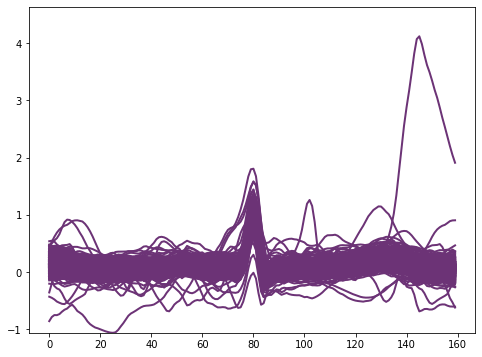


item: 1 cluster: 2 size: 208
statistika klasteryje:  ['N'] [208] 208


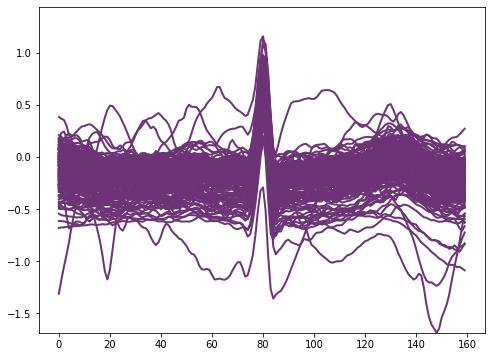


item: 2 cluster: 9 size: 207
statistika klasteryje:  ['N'] [207] 207


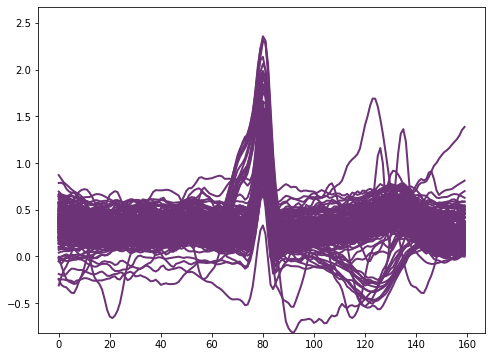


item: 3 cluster: 6 size: 22
statistika klasteryje:  ['N'] [22] 22


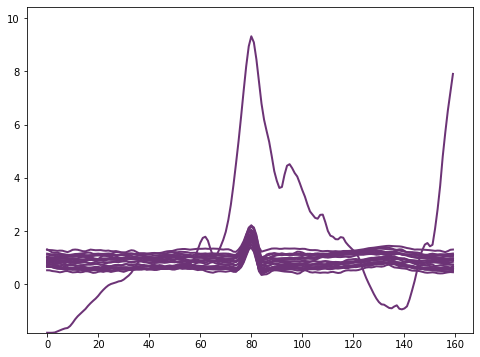


item: 4 cluster: 5 size: 19
statistika klasteryje:  ['N'] [19] 19


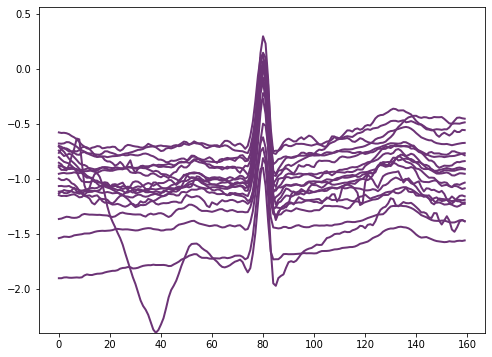


item: 5 cluster: 4 size: 6
statistika klasteryje:  ['N'] [6] 6


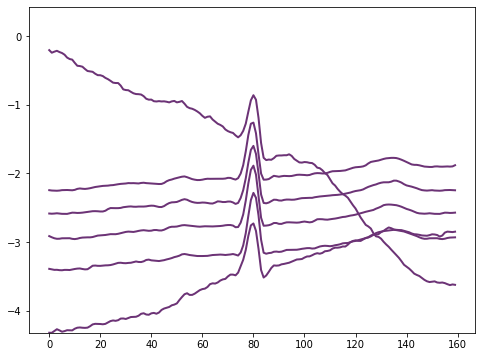


item: 6 cluster: 1 size: 5
statistika klasteryje:  ['N'] [5] 5


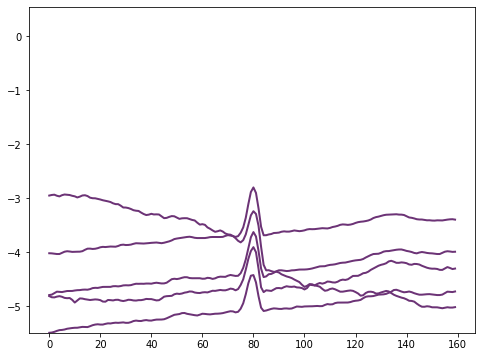


item: 7 cluster: 8 size: 2
statistika klasteryje:  ['N'] [2] 2


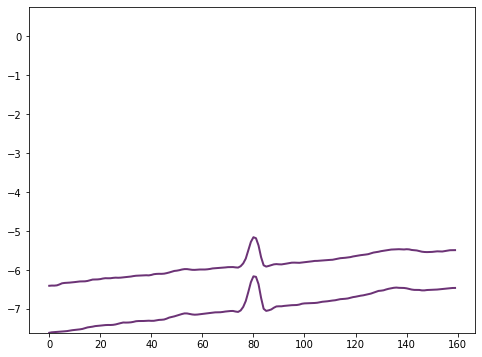


item: 8 cluster: 3 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90096, 'symbol': 'N'}


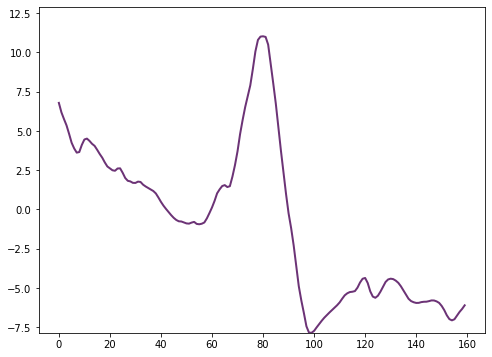


item: 9 cluster: 7 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90270, 'symbol': 'N'}


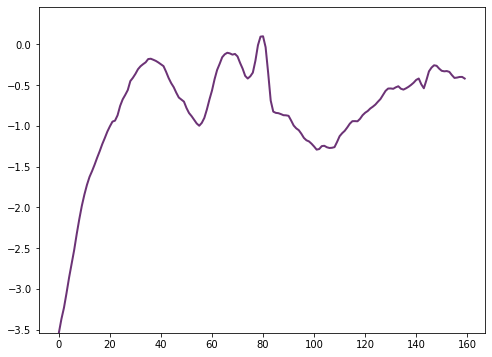


Klasterių statistika pūpsnių grupei su ML anotacija S :
item:      0   cluster:      0   statistika: ['S'] [6] 6
   idx  atr_sample atr_symbol  cluster
0  229       33561          S        0
0  240       35251          S        0
0  269       39111          S        0
0  497       70513          S        0
0  499       70813          S        0
0  804      112604          S        0
S : (idx, rpeak) {229: 33561, 240: 35251, 269: 39111, 497: 70513, 499: 70813, 804: 112604}

item: 0 cluster: 0 size: 6
statistika klasteryje:  ['S'] [6] 6


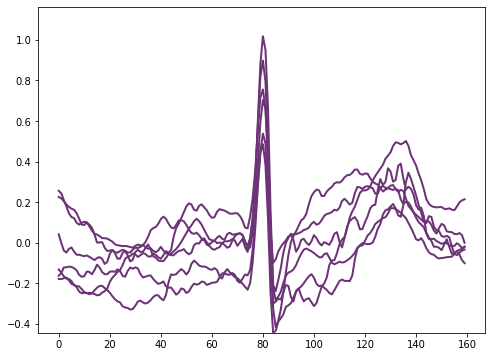


Klasterių statistika pūpsnių grupei su ML anotacija V :
item:      0   cluster:      1   statistika: ['V'] [33] 33
   idx  atr_sample atr_symbol  cluster
0   34        5158          V        1
0   66        9703          V        1
0  193       28239          V        1
0  285       41291          V        1
0  321       46207          V        1
0  328       47115          V        1
V : (idx, rpeak) {34: 5158, 66: 9703, 193: 28239, 285: 41291, 321: 46207, 328: 47115, 409: 58643, 425: 60774, 438: 62409, 443: 63053, 448: 63685, 459: 65110, 463: 65633, 467: 66135, 471: 66646, 515: 73024, 612: 86534, 628: 88608, 633: 89201, 673: 94880, 681: 95957, 709: 99819, 713: 100341, 717: 100860, 745: 104636, 767: 107766, 772: 108425, 775: 108795, 778: 109162, 795: 111311, 887: 124508, 891: 124997, 895: 125505}
item:      1   cluster:      2   statistika: ['V'] [4] 4
   idx  atr_sample atr_symbol  cluster
0  188       27554          V        2
0  310       44751          V        2
0  429       612

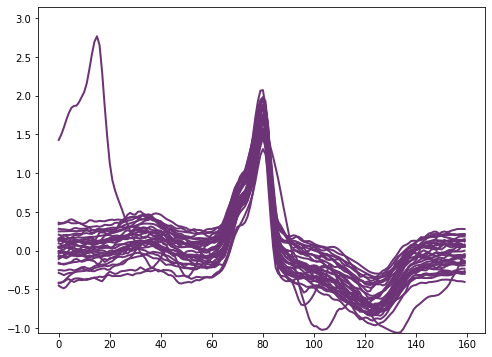


item: 1 cluster: 2 size: 4
statistika klasteryje:  ['V'] [4] 4


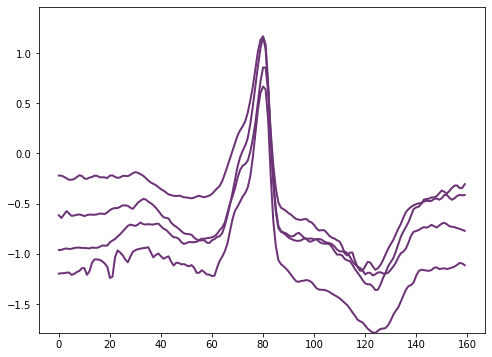


item: 2 cluster: 0 size: 2
statistika klasteryje:  ['V'] [2] 2


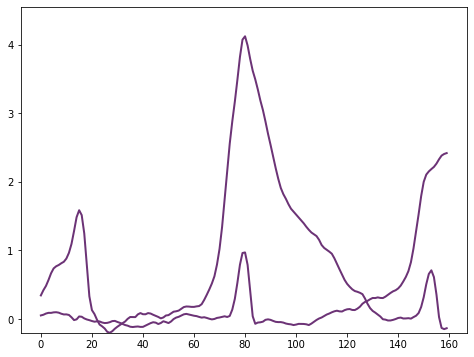

In [25]:
# Grafinis atvaizdavimas - naujas

def show_beats_in_group(signal, df_attr_ml_group_X, group_symbol, w_side, min, max, fig_width, fig_height, max_graphs):
    
    # Sugrupuojame atributus pagal klasterius,
    # surandame klasterių indeksus mažėjančia klasterių dydžio tvarka 
    gr = df_attr_ml_group_X.groupby(['cluster'])
    sr_sizes = gr.size()
    sr_sizes = sr_sizes.sort_values(ascending=False)
    df_sizes = sr_sizes.to_frame(name='sizes').reset_index()

    # čia įdedame spausdinimo ciklą per klasterius, išvesdami klasterių statistiką
    print("\nKlasterių statistika pūpsnių grupei su ML anotacija", group_symbol, ":" )
    for item, row in df_sizes.iterrows():
        cluster = row['cluster']
        df_gr = gr.get_group(cluster)
        atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
        (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
        total = counts.sum()
        print(f'item: {item:>6}   cluster: {cluster:>6}   statistika: {unique} {counts} {total}')

        # S ir V atveju išvedame ekstrasistolių rpeaks
        if (group_symbol == "S" or group_symbol == "V"):
            print(df_gr.head(6))
            dict_X = dict(zip(df_gr['idx'], df_gr['atr_sample']))
            print(group_symbol,': (idx, rpeak)', dict_X)

    # Ciklas per užduotus klasterius
    clusters_sorted = sr_sizes.index
    n_clusters = gr.ngroups

    # Ciklas per klasterius
    for item in range(n_clusters):
        cluster = clusters_sorted[item]
        df_gr = gr.get_group(cluster)
        print('\nitem:', item, 'cluster:', cluster, 'size:', len(df_gr))

        #  Statistika apie pūpsnius klasteryje
        atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
        (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
        total = counts.sum()
        print("statistika klasteryje: ", unique, counts, total)

        if (len(df_gr) == 1):
            dict_attr = {'seq_nr':0, 'rpeak':df_gr['atr_sample'].values[0], 'symbol':df_gr['atr_symbol'].values[0]}
            print(dict_attr)        

        # Grafika
        min, max = get_sequences_min_max(signal, df_gr, w_side)
        show_beats_in_same_plot(signal, df_gr, w_side, min, max, fig_width, fig_height)
        
        if ((max_graphs != 0) and (len(df_gr) != 1)):
            show_beats(signal, df_gr, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)

    return



# Išvedame įrašo atributus
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2} file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")


# ////////////////////////////  PARAMETRAI VAIZDAVIMUI  ////////////////////////////////////////////////////

# Maksimalus grafikų skaičius, išvedant kiekvieną grafiką klasteryje atskirai 
max_graphs = 0

# EKG pūpsnio reikšmių lango į vieną pusę plotis
w_side = 80

# Lango, kuriame vaizduojami grafikai, plotis ir aukštis
fig_width, fig_height = 8, 6

# Užduodame, ar rodyti klasterį su U
U_flag = True

# Rodome klasterių grafikus grupei N
if (not df_attr_ml_group_N.empty):
    show_beats_in_group(signal, df_attr_ml_group_N, 'N', w_side, min, max, fig_width, fig_height, max_graphs)

# Rodome klasterių grafikus grupei S
if (not df_attr_ml_group_S.empty):
    show_beats_in_group(signal, df_attr_ml_group_S, 'S', w_side, min, max, fig_width, fig_height, max_graphs)

# Rodome klasterių grafikus grupei V
if (not df_attr_ml_group_V.empty):
    show_beats_in_group(signal, df_attr_ml_group_V, 'V', w_side, min, max, fig_width, fig_height, max_graphs)    


SubjCode: 101322 userNr: 1013 file_name: 1631032.393 userId: 6144c4fbbd0cc552e427535f recId: 6144cd8bbd0cc52ca32753a4 signal_length: 127999
item:      0   cluster:      0   statistika: ['N'] [366] 366
item:      1   cluster:      7   statistika: ['N'] [222] 222
item:      2   cluster:      9   statistika: ['N'] [200] 200
item:      3   cluster:      4   statistika: ['N'] [26] 26
item:      4   cluster:      2   statistika: ['N'] [18] 18
item:      5   cluster:      1   statistika: ['N'] [7] 7
item:      6   cluster:      6   statistika: ['N'] [6] 6
item:      7   cluster:      5   statistika: ['N'] [2] 2
item:      8   cluster:      3   statistika: ['N'] [1] 1
item:      9   cluster:      8   statistika: ['N'] [1] 1

item: 0 cluster: 0 size: 366
statistika klasteryje:  ['N'] [366] 366


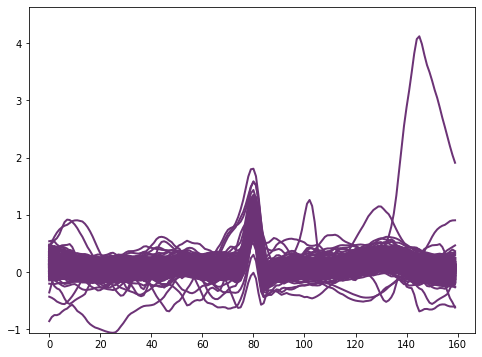

{'seq_nr': 0, 'rpeak': 4365, 'symbol': 'N'}


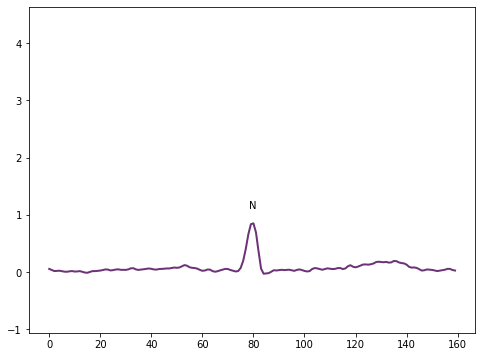

{'seq_nr': 1, 'rpeak': 4507, 'symbol': 'N'}


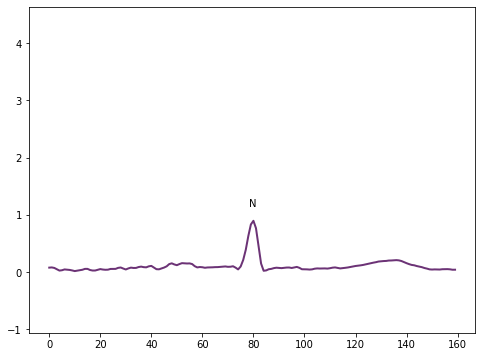

{'seq_nr': 2, 'rpeak': 4649, 'symbol': 'N'}


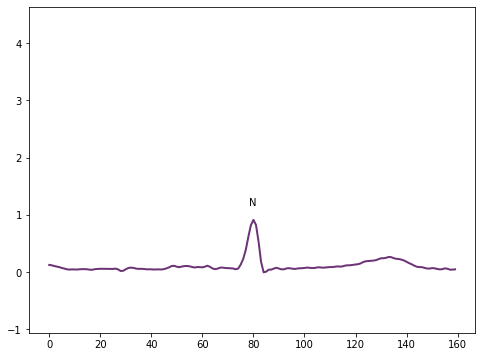


item: 1 cluster: 7 size: 222
statistika klasteryje:  ['N'] [222] 222


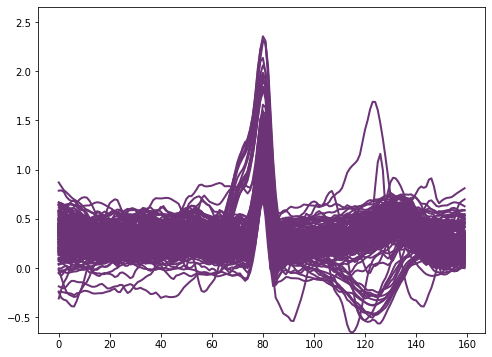

{'seq_nr': 0, 'rpeak': 4924, 'symbol': 'N'}


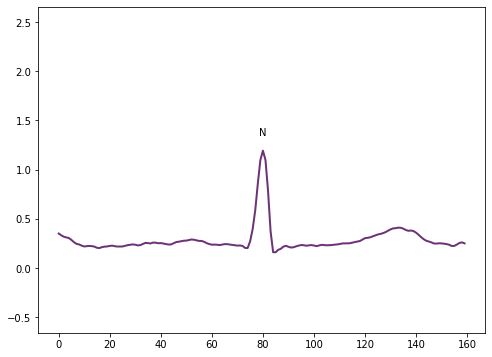

{'seq_nr': 1, 'rpeak': 5060, 'symbol': 'N'}


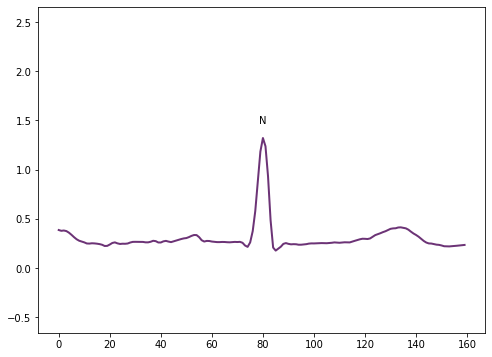

{'seq_nr': 2, 'rpeak': 5335, 'symbol': 'N'}


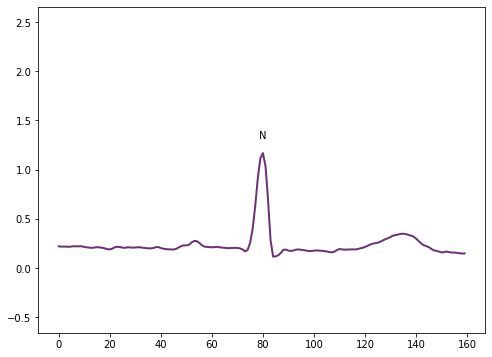


item: 2 cluster: 9 size: 200
statistika klasteryje:  ['N'] [200] 200


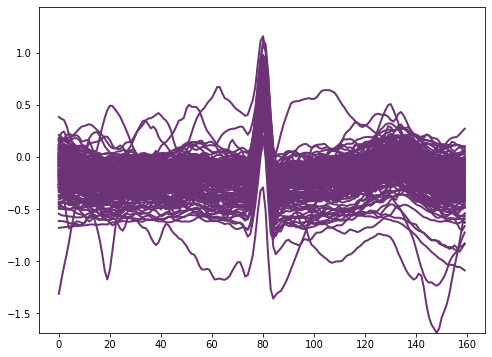

{'seq_nr': 0, 'rpeak': 2466, 'symbol': 'N'}


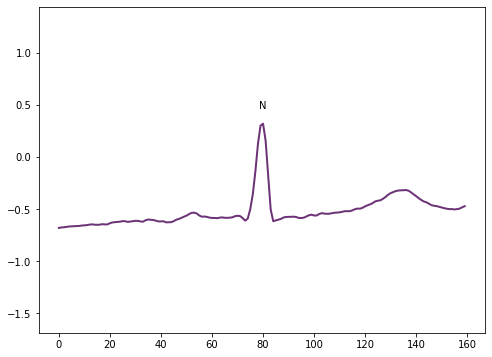

{'seq_nr': 1, 'rpeak': 2618, 'symbol': 'N'}


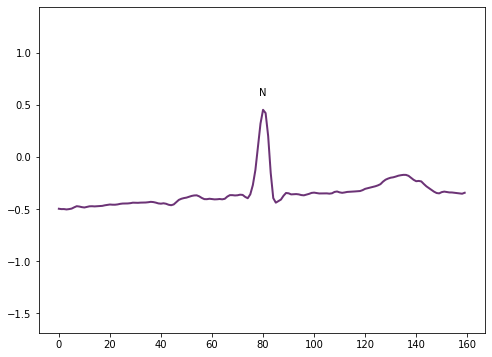

{'seq_nr': 2, 'rpeak': 2770, 'symbol': 'N'}


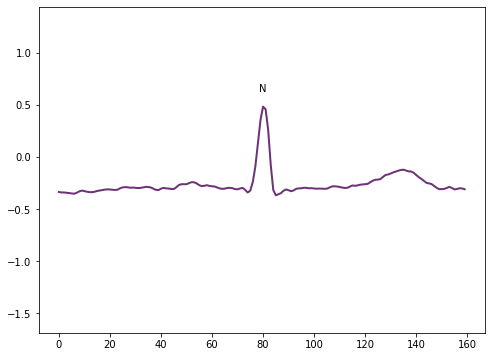


item: 3 cluster: 4 size: 26
statistika klasteryje:  ['N'] [26] 26


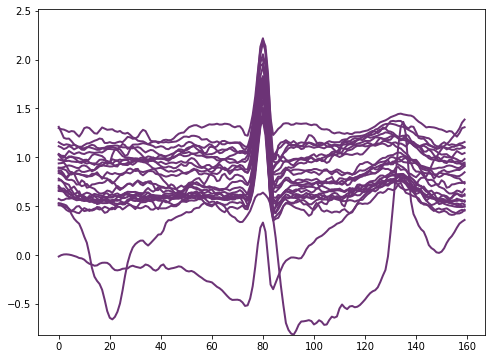

{'seq_nr': 0, 'rpeak': 51708, 'symbol': 'N'}


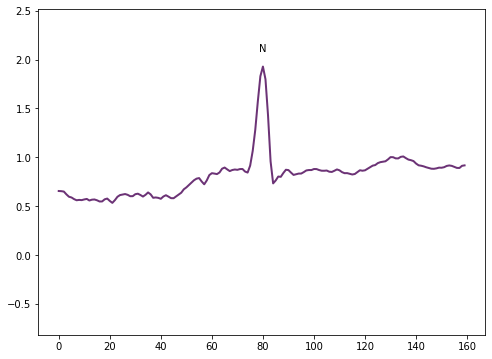

{'seq_nr': 1, 'rpeak': 51857, 'symbol': 'N'}


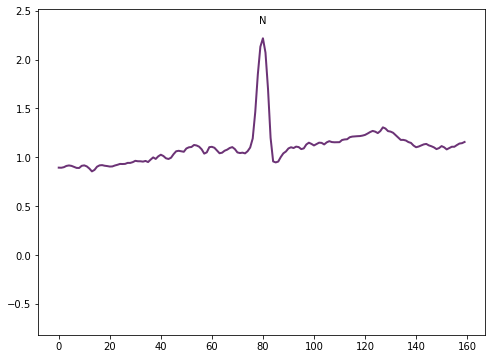

{'seq_nr': 2, 'rpeak': 52003, 'symbol': 'N'}


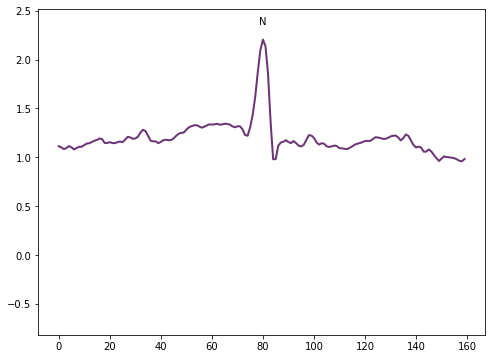


item: 4 cluster: 2 size: 18
statistika klasteryje:  ['N'] [18] 18


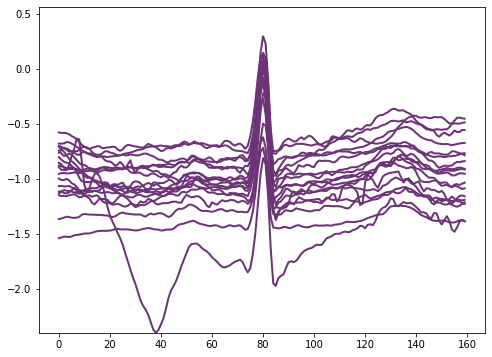

{'seq_nr': 0, 'rpeak': 1815, 'symbol': 'N'}


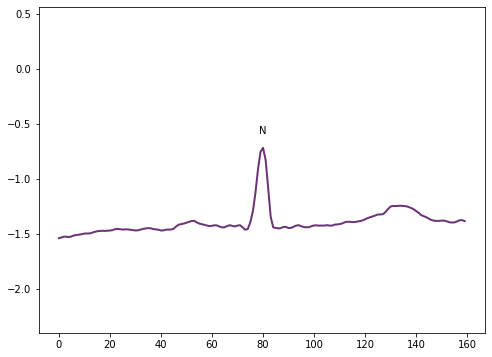

{'seq_nr': 1, 'rpeak': 1983, 'symbol': 'N'}


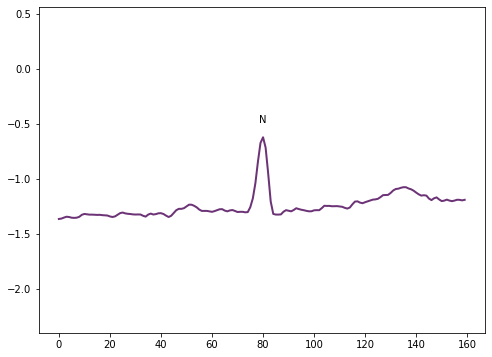

{'seq_nr': 2, 'rpeak': 2150, 'symbol': 'N'}


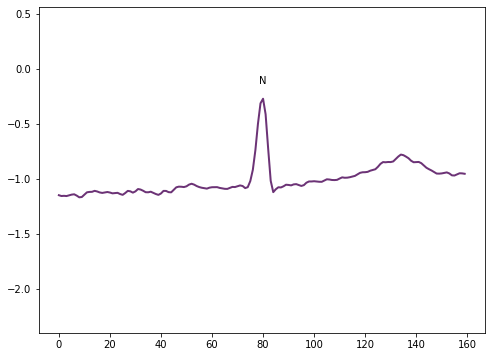


item: 5 cluster: 1 size: 7
statistika klasteryje:  ['N'] [7] 7


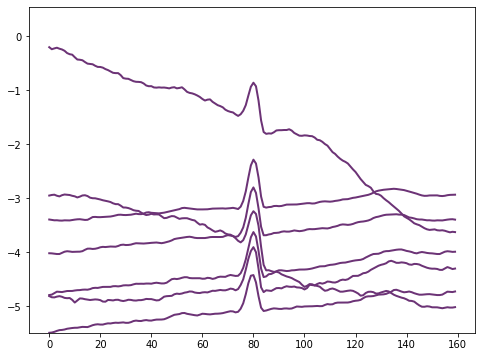

{'seq_nr': 0, 'rpeak': 615, 'symbol': 'N'}


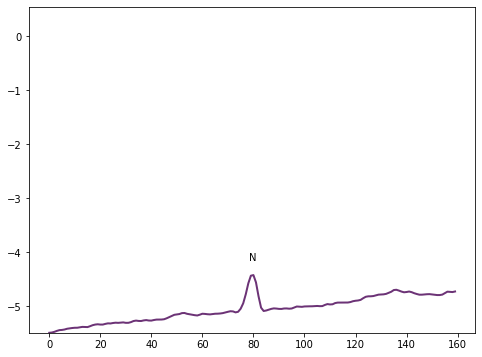

{'seq_nr': 1, 'rpeak': 768, 'symbol': 'N'}


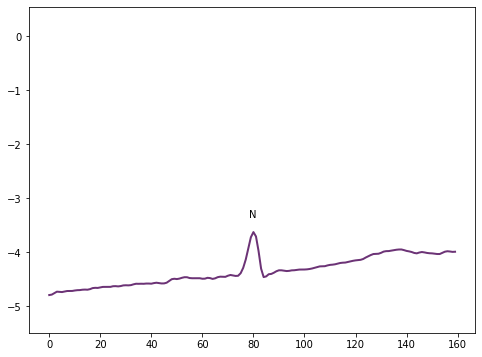

{'seq_nr': 2, 'rpeak': 917, 'symbol': 'N'}


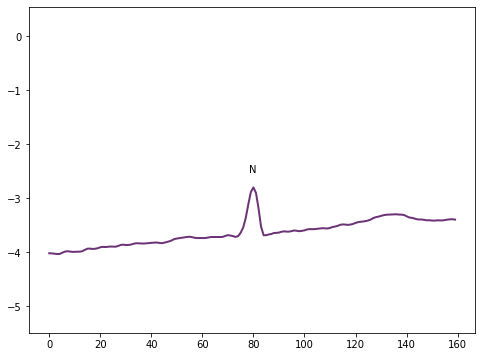


item: 6 cluster: 6 size: 6
statistika klasteryje:  ['N'] [6] 6


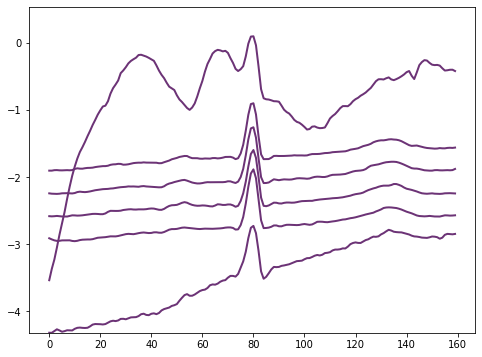

{'seq_nr': 0, 'rpeak': 1207, 'symbol': 'N'}


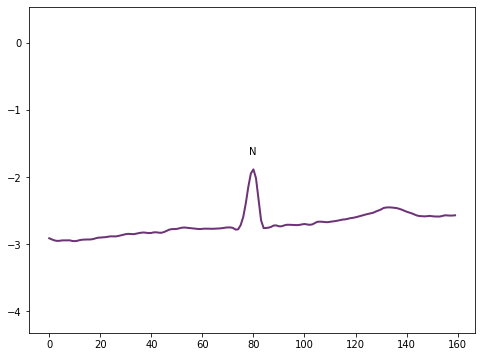

{'seq_nr': 1, 'rpeak': 1353, 'symbol': 'N'}


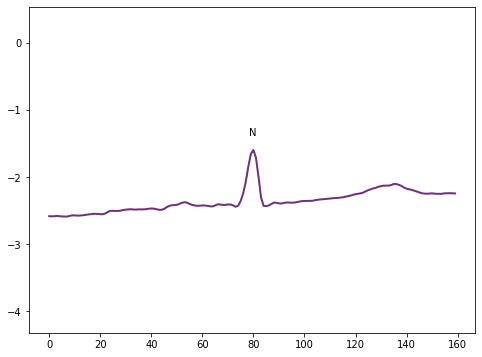

{'seq_nr': 2, 'rpeak': 1503, 'symbol': 'N'}


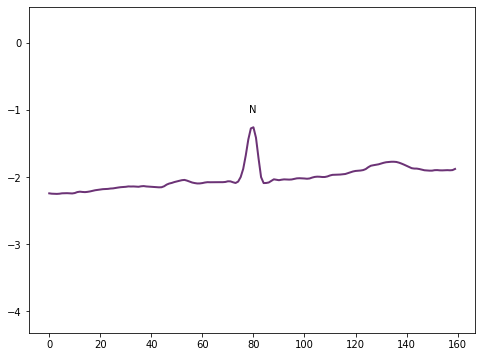


item: 7 cluster: 5 size: 2
statistika klasteryje:  ['N'] [2] 2


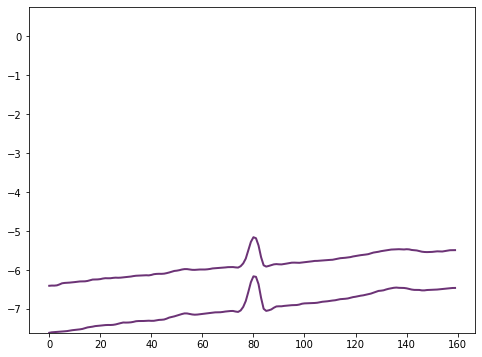

{'seq_nr': 0, 'rpeak': 291, 'symbol': 'N'}


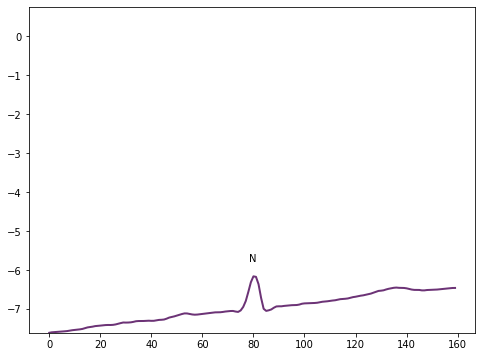

{'seq_nr': 1, 'rpeak': 455, 'symbol': 'N'}


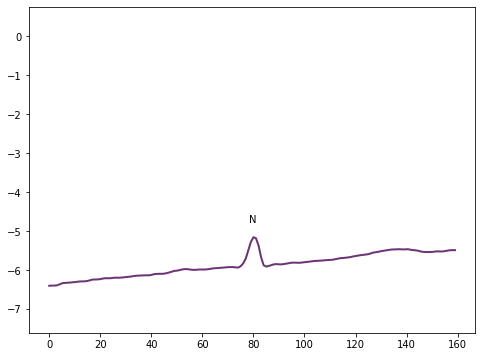


item: 8 cluster: 3 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90096, 'symbol': 'N'}


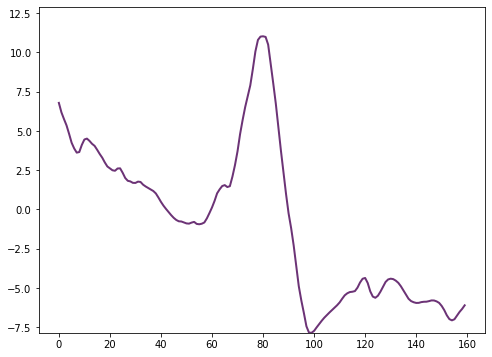


item: 9 cluster: 8 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90012, 'symbol': 'N'}


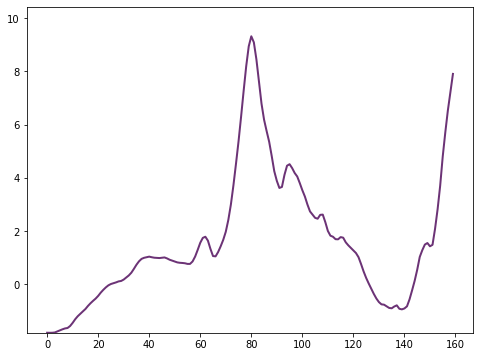

item:     XX   cluster:     99   statistika: ['U'] [15] 15

item: XX cluster: 99 size: 15
statistika: ['U'] [15] 15
U: (idx, rpeak) {0: 49788, 1: 50082, 2: 50233, 3: 50689, 4: 50981, 5: 57496, 6: 77551, 7: 78138, 8: 88315, 9: 88543, 10: 88848, 11: 88977, 12: 89717, 13: 91750, 14: 109064}


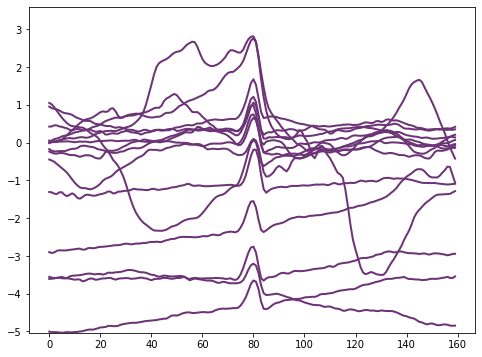

{'seq_nr': 0, 'rpeak': 49788, 'symbol': 'U'}


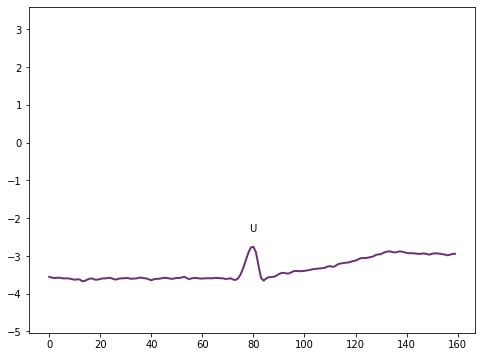

{'seq_nr': 1, 'rpeak': 50082, 'symbol': 'U'}


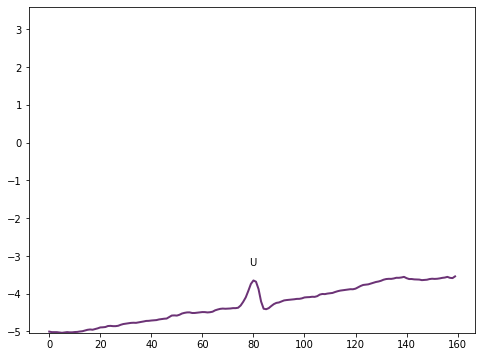

{'seq_nr': 2, 'rpeak': 50233, 'symbol': 'U'}


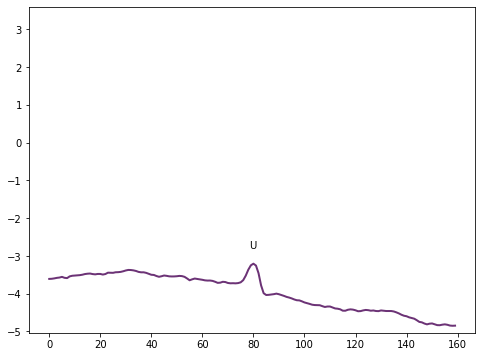

In [13]:
# Grafinis atvaizdavimas - senas

# Išvedame įrašo atributus
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2} file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")


# ////////////////////////////  PARAMETRAI VAIZDAVIMUI  ////////////////////////////////////////////////////

# Maksimalus grafikų skaičius, išvedant kiekvieną grafiką klasteryje atskirai 
max_graphs = 3

# EKG pūpsnio reikšmių lango į vieną pusę plotis
w_side = 80

# Lango, kuriame vaizduojami grafikai, plotis ir aukštis
fig_width, fig_height = 8, 6

# Užduodame, ar rodyti klasterį su U
U_flag = True

# Užduodame, kuriuos klasterius rodysime (eilės nr iš df_sizes)
start, end = 0, 20

# Klaidos tikrinimas
# atr_symbol_be_U_n = np.array(list(df_attr_be_U['atr_symbol']))
# if (not np.array_equal(atr_symbol_be_U_n, atr_symbol_be_U)):
#     raise Exception("nesutampa atr_symbol_be_U")

# # Bendra statistika apie pūpsnius be 'U'
# (unique, counts) = np.unique(atr_symbol_be_U, return_counts=True)
# total = counts.sum()
# print("\nBendra statistika:")
# print("Klasės be 'U': ", unique, counts, total)

# # Bendra statistika apie pūpsnius su 'U'
# atr_symbol_su_U = np.array(list(df_attr_su_U['atr_symbol']))
# (unique, counts) = np.unique(atr_symbol_su_U, return_counts=True)
# total = counts.sum()
# print("Klasės su 'U' (be 1-o ir paskutinio pūpsnio):", unique, counts, total)
# print()

# Sugrupuojame atributus pagal klasterius,
# surandame klasterių indeksus mažėjančia klasterių dydžio tvarka 
gr = df_attr_ml_group_N.groupby(['cluster'])
sr_sizes = gr.size()
sr_sizes = sr_sizes.sort_values(ascending=False)
df_sizes = sr_sizes.to_frame(name='sizes').reset_index()

# čia įdedame spausdinimo ciklą per klasterius, išvesdami klasterio statistiką
for item, row in df_sizes.iterrows():
    cluster = row['cluster']
    df_gr = gr.get_group(cluster)
    atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
    (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
    total = counts.sum()
    print(f'item: {item:>6}   cluster: {cluster:>6}   statistika: {unique} {counts} {total}')


# Koreguojame rodomų klasterių kiekį
n_clusters = gr.ngroups
if (end > n_clusters):
    end = n_clusters


# Ciklas per užduotus klasterius
clusters_sorted = sr_sizes.index

# Ciklas per klasterius
for item in range(start,end):
    cluster = clusters_sorted[item]
    df_gr = gr.get_group(cluster)
    print('\nitem:', item, 'cluster:', cluster, 'size:', len(df_gr))

    #  Statistika apie pūpsnius klasteryje
    atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
    (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
    total = counts.sum()
    print("statistika klasteryje: ", unique, counts, total)

    df_S = df_gr.loc[df_gr['atr_symbol'] == 'S', 'atr_sample']
    if (not df_S.empty):
        dict_S = df_S.to_dict()
        print('S: (idx, rpeak)', dict_S)

    df_V = df_gr.loc[df_gr['atr_symbol'] == 'V', 'atr_sample']
    if (not df_V.empty):
        dict_V = df_V.to_dict()
        print('V: (idx, rpeak)', dict_V)

    if (len(df_gr) == 1):
        dict_attr = {'seq_nr':0, 'rpeak':df_gr['atr_sample'].values[0], 'symbol':df_gr['atr_symbol'].values[0]}
        print(dict_attr)        

    # Grafika
    min, max = get_sequences_min_max(signal, df_gr, w_side)
    show_beats_in_same_plot(signal, df_gr, w_side, min, max, fig_width, fig_height)
    
    if ((max_graphs != 0) and (len(df_gr) != 1)):
        show_beats(signal, df_gr, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)


# Išvedame klasterį su anotacija 'U'

# Klasteris U: statistika 
atr_symbol_su_U = np.array(list(df_attr_su_U['atr_symbol']))
(unique, counts) = np.unique(atr_symbol_su_U, return_counts=True)
total = counts.sum()
print(f'item: {"XX":>6}   cluster: {99:>6}   statistika: {unique} {counts} {total}')

if (U_flag):
    atr_symbol_su_U = np.array(list(df_attr_su_U['atr_symbol']))
    (unique, counts) = np.unique(atr_symbol_su_U, return_counts=True)
    total = counts.sum()
    print(f'\nitem: {"XX":>1} cluster: {99:>1} size: {len(atr_symbol_su_U)}') 
    print(f'statistika: {unique} {counts} {total}')

    df_U = pd.Series(df_attr_su_U['atr_sample'])
    if (not df_U.empty):
        dict_U = df_U.to_dict()
        print('U: (idx, rpeak)', dict_U)

    if (len(df_attr_su_U) == 1):   
        dict_attr = {'seq_nr':0, 'rpeak':df_attr_su_U['atr_sample'].values[0], 'symbol':df_attr_su_U['atr_symbol'].values[0]}
        print(dict_attr)

    min, max = get_sequences_min_max(signal, df_attr_su_U, w_side)
    show_beats_in_same_plot(signal, df_attr_su_U, w_side, min, max, fig_width, fig_height)

    if ((max_graphs != 0)  and (len(df_attr_su_U) != 1)):
        show_beats(signal, df_attr_su_U, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)

In [ ]:
# //////////////// KLASTERIZACIJA SENA //////////////////////////////////////////////////////
# https://machinelearningmastery.com/clustering-algorithms-with-python/
# K_MEANS

from sklearn.cluster import KMeans

# Klasterizuojami ML anotuoti pūpsniai atskirai kiekvienoje iš grupių su ML anotacijomis N, S, V.  
# Klasterizacija atliekama esant pakankamam N, S ar V grupės dydžiui.
# U grupė neklasterizuojama, klasterio duomenys jau parengti: df_attr_su_U.

# Išeities duomenys klasterizacijai: masyvas df_attr_features_be_U

start_time = time.time()

# Nustatomi reikiami grupių dydžiai klasterizacijai.
#  ........


# Išskiriame ML anotacijų grupes N, S, V
# df_attr_features_be_U
# print(df_attr_features_be_U[['idx','atr_sample']].head())


# Sugrupuojame atributus pagal ML grupes
ml_groups = df_attr_features_be_U.groupby(['atr_symbol'])

# surandame klasterių indeksus mažėjančia klasterių dydžio tvarka 
# sr_sizes = gr.size()
# sr_sizes = sr_sizes.sort_values(ascending=False)
# df_sizes = sr_sizes.to_frame(name='sizes').reset_index()

# čia įdedame spausdinimo ciklą per ML anotacijų grupes, išvesdami grupės statistiką
for ml_symbol, df_attr_features_ml_group in ml_groups:
    print('\nml_symbol:', ml_symbol, 'len:', len(df_attr_features_ml_group))
    print(df_attr_features_ml_group[['idx','atr_sample', 'atr_symbol']].head())



# Klasterizuojame ML grupes kiekvieną atskirai

# N grupės klasterizacija
df_attr_features_ml_group_N = ml_groups.get_group('N')
# print('\nml_symbol:', 'N', 'len:', len(df_attr_features_ml_group_N))
# print(df_attr_features_ml_group_N[['idx','atr_sample', 'atr_symbol']].head())

# Paliekame tik užduotus požymius ir normalizuojame
df_tmp = df_attr_features_ml_group_N[all_features]
# print(data_frame_init.head())
# Duomenis normalizuojame
X = scaler.transform(df_tmp)

# define the model
model = KMeans(n_clusters)

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)
# print(type(yhat), yhat.shape)

# retrieve unique clusters
clusters = np.unique(yhat)
# print(clusters)

# Testavimui
# for cluster in clusters:
#     # get row indexes for samples with this cluster
    # row_ix = np.where(yhat == cluster)
    # print(type(row_ix))
    # print(row_ix[0])
    # row_lst = row_ix[0]
    # print(row_lst[:20])

# Paliekame masyvus tik su atributais, be požymių, požymių stulpelius panaikiname
df_attr_ml_group_N = df_attr_features_ml_group_N.drop(all_features, axis=1, inplace=False)

# Papildome atributus klasterių numeriais 
df_attr_ml_group_N['cluster'] = list(yhat)
# print("\nKlasteris be U: df_attr_be_U")
print("\nMasyvas N: df_attr_ml_group_N len:", len(df_attr_ml_group_N) )
print(df_attr_ml_group_N.columns)

print(df_attr_ml_group_N.head(10))

end_time = time.time()
print('\nklasterizacija:')
runtime(end_time-start_time)
